# **run load_data.ipynb BEFORE running this!**

In [48]:
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
s = {
    'problem'           : "regression",
    'approach'          : "few-shot learning",
    'method'            : "non-parametric",
    'algorithm'         : "siamese network",
    'goal'              : "learn a distribution using few samples from it",
    'input'             : "samples from a distribution",
    'input type'        : "vectors",
    'input meaning'     : "spectrum", 
    'output'            : "samples from a distribution",
    'output type'       : "one number",
    'output meaning'    : "temperature or pressure, depending on distribution",
    'number of ways'    : 2,
    'number of shots'   : 1,
    'number of folds'   : 8,
    'support-query ratio': 0.8,
    'task size'         : 5,
    'learning rate'     : 5e-5,
    'feature dimension' : 16,
    'epoch'             : 1000,
    'epoch development' : 36,
    'cross validation round': 16,
    'cross validation round-development' : 3,
    'best model folder' : 'siamese_best_model/'
}

In [49]:
import data_accessor as acc
data_names_list = [
    'temperature_230509_discrete',
    'pressure_230516_discrete'
    ]
data_dictionary = acc.setup(data_names_list)

loading temperature_230509_discrete__________________________
	input shape (number, dimension): (6000, 10000)
	label shape (number, dimension): (6000, 1)
	there are 16 folds
	4200 for training, 600 for validating, 1200 for testing
loading pressure_230516_discrete__________________________
	input shape (number, dimension): (5000, 10000)
	label shape (number, dimension): (5000, 1)
	there are 16 folds
	3500 for training, 500 for validating, 1000 for testing


In [50]:
np.asarray(data_dictionary['temperature_230509_discrete']['train indices']).shape

(16, 4200)

In [51]:
# task layout July 5, 2023

# siamese network extract feature space difference
# auxiliary network convert that difference into label difference

In [52]:
input_dimension = 10000
output_dimension = 1

In [53]:
import torch.nn as nn
class SiameseNetwork(torch.nn.Module):
    def __init__(self, device, input_dimension, feature_dimension, output_dimension):
        """ Input: input, anchor, anchor label
        Output: prediction for input"""
        super().__init__()
        self.input_dimension = input_dimension
        self.hidden_dimension = 32
        self.feature_dimension = feature_dimension
        self.output_dimension = output_dimension
        self.device = device
        self.feature_sequential = torch.nn.Sequential(
            torch.nn.Linear(self.input_dimension, self.hidden_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.hidden_dimension, self.hidden_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.hidden_dimension, self.feature_dimension)
        )
        self.auxiliary_sequential = torch.nn.Sequential(
            torch.nn.Linear(self.feature_dimension, self.feature_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.feature_dimension, self.feature_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.feature_dimension, self.output_dimension)
        )
        self.to(device)
        self.float()
    def forward(self, input, anchor, anchor_label):
        feature_input = self.feature_sequential(input)
        feature_anchor = self.feature_sequential(anchor)
        feature_space_difference_input_from_anchor = feature_input - feature_anchor
        label_difference_input_from_anchor = self.auxiliary_sequential(feature_space_difference_input_from_anchor)
        prediction = anchor_label + label_difference_input_from_anchor
        return prediction

In [54]:
import matplotlib.pyplot as plt
def plot_loss(train_loss, valid_loss):
    plt.subplot()
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.legend(["train loss", "valid loss"], loc ="upper right")
    plt.show()

In [55]:
from tools import SaveBestModel, PatienceEarlyStopping, Scheduler 
class Manager:
    """ DOES: train & evaluate a Siamese network
        """
    def __init__(self, epoch, cross_validation_round):
        self._network = SiameseNetwork(device, 10000, 16, 1)
        self._network.apply(self.initializer)
        self._learning_rate = 1e-4
        self._optimizer = torch.optim.Adam(
            params=self._network.parameters(), lr=self._learning_rate,
            weight_decay=3e-3)
        self._energy = nn.MSELoss()
        self._train_loss = []
        self._valid_loss = []
        self._test_loss = []
        self._epoch = epoch
        self._stopper = PatienceEarlyStopping(patience=10, min_delta=1e-7)
        self._cross_validation_round = cross_validation_round
        self._saver = SaveBestModel(s['best model folder'])
        self._scheduler = Scheduler(optimizer=self._optimizer, 
                        minimum_learning_rate=1e-6,
                        patience=5,
                        factor=0.5)
    def initializer(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_normal_(layer.weight) # normal version
    def _step(self, job):
        input, input_label, anchor, anchor_label = job
        # print(f"input dtype is {input_1.dtype}")
        prediction = self._network(input, anchor, anchor_label)
        loss = self._energy(input_label, prediction)
        return loss     
    def train(self, train_dataloader, valid_dataloader):
        """ DOES: calculate loss from tasks
            NOTE: we have a BATCH of tasks here """
        for e in range(self._epoch):
            # print(f"train() epoch {e}")
            batch_train_loss = []
            for _, batch in enumerate(train_dataloader): 
                loss = self._step(batch)
                loss.backward()
                self._optimizer.step()
                batch_train_loss.append(loss.item())
            self._train_loss.append(np.mean(batch_train_loss))
            batch_valid_loss = []
            with torch.no_grad():
                for _, batch in enumerate(valid_dataloader): 
                    loss = self._step(batch)
                    batch_valid_loss.append(loss.item())
            self._valid_loss.append(np.mean(batch_valid_loss))
            # saving, early stopping, scheduler for EACH epoch!
            self._saver(current_loss=np.mean(batch_valid_loss), 
                  model=self._network, 
                  round=self._cross_validation_round
                  )
            self._scheduler(np.mean(batch_valid_loss))
            self._stopper(np.mean(batch_valid_loss))
            if self._stopper.early_stop == True:
                print(f"EARLY STOPPING @ epoch {e}")
                break
        # summary printout, after we're done with epochs
        print(f"min train loss: {np.min(self._train_loss)}")
        print(f"min valid loss: {np.min(self._valid_loss)}")
        plot_loss(self._train_loss, self._valid_loss)
        return np.min(self._valid_loss)
    def test(self, test_dataloader):
        with torch.no_grad():
            batch_test_loss = []
            with torch.no_grad():
                for _, batch in enumerate(test_dataloader): 
                    loss = self._step(batch)
                    batch_test_loss.append(loss.item())
            self._test_loss.append(np.mean(batch_test_loss)) 
        return np.min(self._test_loss)

CV round 0
EARLY STOPPING @ epoch 18
min train loss: 0.2929420339112932
min valid loss: 0.2730921130431326


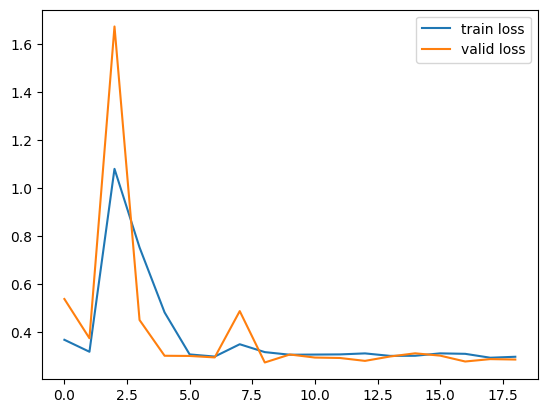

current loss 0.2730921130431326 < inf
CV round 1
EARLY STOPPING @ epoch 12
min train loss: 0.25007855779293814
min valid loss: 0.19603392873939715


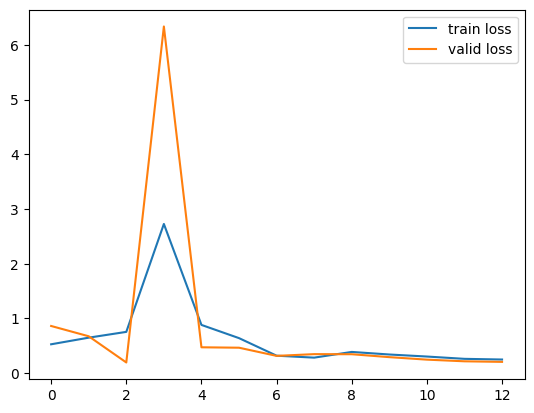

current loss 0.19603392873939715 < 0.2730921130431326
CV round 2
EARLY STOPPING @ epoch 27
min train loss: 0.17807015454904598
min valid loss: 0.13931215593689367


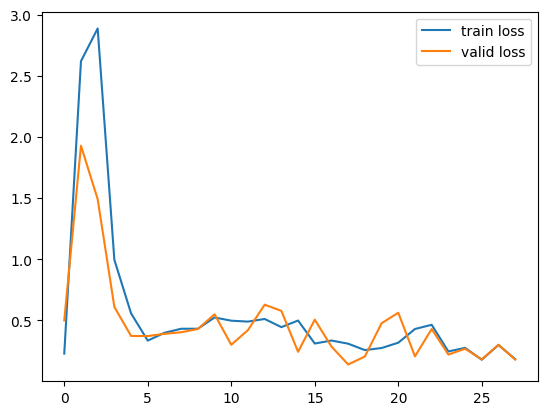

current loss 0.13931215593689367 < 0.19603392873939715
best model is: CV=2.pth


In [56]:
from torch.utils.data import DataLoader
from tools import SiameseDataset, SaveBestCrossValidationModel
CV_saver = SaveBestCrossValidationModel(s['best model folder'])
test_indices = data_dictionary['temperature_230509_discrete']['test indices']
epoch = s['epoch']
for cross_validation_round, (train, valid) in enumerate(zip(
    data_dictionary['temperature_230509_discrete']['train indices'],
    data_dictionary['temperature_230509_discrete']['valid indices'])):
    if cross_validation_round < s['cross validation round-development']:
        print(f"CV round {cross_validation_round}")
        network_object = Manager(epoch, cross_validation_round)
        valid_loss = network_object.train(
            DataLoader(SiameseDataset(
            data_dictionary['temperature_230509_discrete']['data'],
            data_dictionary['temperature_230509_discrete']['label'],
            data_dictionary['temperature_230509_discrete']['train indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=32),
            DataLoader(SiameseDataset(
            data_dictionary['temperature_230509_discrete']['data'],
            data_dictionary['temperature_230509_discrete']['label'],
            data_dictionary['temperature_230509_discrete']['valid indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=32))
        CV_saver(current_loss=valid_loss, round=cross_validation_round)
print(f"\nbest model is: {CV_saver.best_model_name} with {CV_saver.current_best_loss}")

In [69]:
network_object._network.load_state_dict(torch.load(s['best model folder'] + CV_saver.best_model_name))
test_loss = network_object.test(
            DataLoader(SiameseDataset(
            data_dictionary['temperature_230509_discrete']['data'],
            data_dictionary['temperature_230509_discrete']['label'],
            data_dictionary['temperature_230509_discrete']['test indices'],
            device=device,), shuffle=False, batch_size=32))
print(f"testing loss: {test_loss}")

testing loss: 0.16414695978164673


In [71]:
# test_model = SiameseNetwork(device, 10000, 16, 1)
# test_model.load_state_dict(torch.load(s['best model folder'] + CV_saver.best_model_name))
# test_network_object = Manager(1, 1)
# test_network_object._network = test_model
# test_loss = test_network_object.test(
#             DataLoader(SiameseDataset(
#             data_dictionary['temperature_230509_discrete']['data'],
#             data_dictionary['temperature_230509_discrete']['label'],
#             data_dictionary['temperature_230509_discrete']['test indices'],
#             device=device,), shuffle=False, batch_size=32))
# print(f"testing loss: {test_loss}")

testing loss: 0.1677138554422479
